## Training a high-dimensional neural network to build a predictive model for hedging using real world data
### Machine Learning/Finance/Mathematics
#### Timothy Burt
##### This proof-of-concept generates parameters utilizing nonlinear PDE Black-Scholes-Barenblatt equation which can be used to determine when to buy or sell a derivative stock & its volatility. In addition it could be expanded to use other PDEs and data from other sources.

### Outline

Nonlinear highly dimensional data is becoming increasingly common in today's world. It is becoming increasingly difficult to building predictive models that accurately predict or even describe this highly chaotic data and linear approximations for dimensionality reduction such as principal component analysis (PCA) may destroy useful information. 

### For this project I would employ the deep2BSDE (second-order backward stochastic differential equation) algorithm [1] to train a neural network to build a model for derivative securities (swap/option contracts, futures, forwards). 

The nonlinear PDE Black-Scholes-Barenblatt equation from Arbitrage Pricing Theory [2] allows for the modeling of option prices with uncertain volatility and interest rates given appropriate boundary conditions. It may be represented as

$$\frac{1}{2} \sigma^2 (S,t) S^2 \frac{\partial ^2 V}{\partial S^2}+r(S,t)S \frac{\partial V}{\partial S}-r(S,t)V-\frac{\partial V}{\partial t}=0 \label{eq:bsb}$$

where $\sigma$ is the variable volatility, r is the market (risk-free) interest rate, S is the asset price, and t is the time.

The deep2BSDE algorithm utilizes a stochastic gradient descent method to train a neural network to find the parameters for a specific equation by analyzing many example datasets.

### The goal of this project would be to deliver a web application or GUI where users can select a particular type of derivative and historical data pulled at runtime from online databases. The ideal case for a future derivative of that type (mean-field approximation) would be displayed along with the Black-Scholes equation parameters, which a user can vary to look at other cases. The best and worst case scenarios would also be displayed to the user based on the maximum and minimum volatilities from the model. 

### The power of machine learning can be heavily exploited and a plethora of enlightening visualization schemes utilized with a model such as this. The cross correlation between types of derivative securities or for any other time-dependent y(t) series of data which could be provided by the user could be computed and shown realtime. A causality chain could be generated showing the most heavily dependent securities on other ones to perturbation of the asset price, allowing better estimates on the potential profit/loss it can bring. The deep2BDSE model is high adaptable as it is a nonlinear PDE solver, meaning this project could also be used to model disease proliferation, crop yields, and crime statistics. 

### It could also possibly give theoretical insight into the possible "missing physics" from a particular PDE used in those models [3]. It would allow mathematicians to develop better PDEs to model events, and with the enormous number of sensors gathering physical data woldwide correlations between the physics and social sciences could be found which may lead to event/disaster prediction and the better understanding of the connection between physics & life.

In the deep2BDSE model the dimensionality is the number of training sets and the batch size is the total number of timesteps. 

Now let's look at the deep2BDSE model applied to hisotrical NYMEX WTI crude oil futures data, courtesy of Quandl. 

In [8]:
import matplotlib.pyplot as plt
import scipy.optimize as sp
import quandl
import datetime
import numpy as np
import pandas as pd

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20,5)
plots_fold = '../Plots'
d_fold = '../Data'
fn = 'fdata'

Populating the interactive namespace from numpy and matplotlib


In [2]:
def futures_rollover_weights(start_date, expiry_dates, contracts, rollover_days=5):
    """This constructs a pandas DataFrame that contains weights (between 0.0 and 1.0)
    of contract positions to hold in order to carry out a rollover of rollover_days
    prior to the expiration of the earliest contract. The matrix can then be3
    'multiplied' with another DataFrame containing the settle prices of each
    contract in order to produce a continuous time series futures contract.
    https://www.quantstart.com/articles/continuous-futures-contracts-for-backtesting-purposes"""

    # Construct a sequence of dates beginning from the earliest contract start
    # date to the end date of the final contract
    dates = pd.date_range(start_date, expiry_dates[-1], freq='B')

    # Create the 'roll weights' DataFrame that will store the multipliers for
    # each contract (between 0.0 and 1.0)
    roll_weights = pd.DataFrame(np.zeros((len(dates), len(contracts))),
                                index=dates, columns=contracts)
    prev_date = roll_weights.index[0]

    # Loop through each contract and create the specific weightings for
    # each contract depending upon the settlement date and rollover_days
    for i, (item, ex_date) in enumerate(expiry_dates.iteritems()):
        if i < len(expiry_dates) - 1:
            roll_weights.loc[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=rollover_days + 1, freq='B')

            # Create a sequence of roll weights (i.e. [0.0,0.2,...,0.8,1.0]
            # and use these to adjust  the weightings of each future
            decay_weights = np.linspace(0, 1, rollover_days + 1)
            roll_weights.loc[roll_rng, item] = 1 - decay_weights
            roll_weights.loc[roll_rng, expiry_dates.index[i+1]] = decay_weights
        else:
            roll_weights.loc[prev_date:, item] = 1
        prev_date = ex_date
    return roll_weights

In [ ]:
# Modified code originally from:
# https://www.quantstart.com/articles/continuous-futures-contracts-for-backtesting-purposes

quandl.ApiConfig.api_key="UeuJWGqy_Gq-C6fwr-uT"
lett = ['F','G','H','J','K','M','N','Q','U','V','X','Z']
yrs = [str(i) for i in range(2006,2019)]
wti_near_s = "CME/CL%s%s" % (lett[0],yrs[0])
wti_start = wti_near_s
dim = 100
dim_extra = 30
dim += dim_extra
bins = 30
wti_all = []
wti_int = []
iterator = 0
for i in range(len(yrs)):
    for j in range(len(lett)):
        if iterator > dim-1:
            break
        else:
            if (iterator%12 == 11):
                yrs_cur = yrs[i+1]
                mon = 12
            else:
                yrs_cur = yrs[i]
                mon = 11
            wti_far_s = "CME/CL%s%s" % (lett[(iterator+1)%12],yrs_cur)
            if ((iterator + 1)%10) == 0:    
                print('Iteration %d out of %d, %s - %s' % (iterator+1,dim,wti_near_s,wti_far_s))
            dt_start = datetime.datetime(int(yrs_cur),(iterator%12)+1, 1)
            dt_end = datetime.datetime(int(yrs_cur),((iterator+1)%12)+1, 1)
            wti_near = quandl.get(wti_near_s)
            wti_far = quandl.get(wti_far_s)
            # Make sure to adjust the contracts to reflect your current near/far contracts
            wti = pd.DataFrame({wti_near_s[4:]: wti_near['Settle'],
                                wti_far_s[4:]: wti_far['Settle']}, index=wti_far.index)
            
            int_str = ['Open Interest','Prev. Day Open Interest']

            wti_near_int = pd.DataFrame(wti_near[wti_near.iloc[:,-1] != 0], index=wti_near.index)
            wti_far_int = pd.DataFrame(wti_far[wti_far.iloc[:,-1] != 0], index=wti_far.index)
            
            # Create the dictionary of expiry dates for each contract
            expiry_dates = pd.Series({wti_near_s[4:]: dt_start,
                                     wti_far_s[4:]: dt_end}).sort_values()
        
            # Obtain the rollover weighting matrix/DataFrame
            weights = futures_rollover_weights(wti_near.index[0], expiry_dates, wti.columns)
            
            wti_cts = (wti * weights).sum(1).dropna()
            wti_near_int = wti_near_int.iloc[:,-1].dropna()
            wti_far_int = wti_far_int.iloc[:,-1].dropna()
            #r_near = (wti_near_int.astype(float) / wti_near_int.iloc[-1].astype(float))**(1.0/9.0) - 1.0
            r_far = (wti_far_int.astype(float) / wti_far_int.iloc[-1].astype(float))**(1.0/9.0) - 1.0
            #print(r_near)
            r = r_far.iloc[-bins] - r_far.iloc[-1]
            wti_cts = list(wti_cts.tail(bins))

            wti_all.append(wti_cts)
            wti_int.append(r)
            wti_near_s = "CME/CL%s%s" % (lett[(iterator+1)%12],yrs_cur)
            
            iterator += 1

# Output the merged series of contract settle prices
wti_end = wti_near_s
wti_all = np.asarray(wti_all)
wti_int_all = np.asarray(wti_int)
# normalize to R^d from (0,1)
allones = np.ones((dim,bins))
wti_all_avg = np.mean(wti_all) * allones
wti_all_std = np.std(wti_all) * allones
wti_all_norm = np.zeros((dim,bins))
wti_all_max = np.max(wti_all, axis=1)
wti_all_min = np.min(wti_all, axis=1)
wti_all_norm_half = []
wti_all_norm_tfour = []

for i in range(dim):
    for j in range(0, bins):
        if wti_all[i,j] < 0.0:
            wti_all_norm[i,j] = np.abs(wti_all[i,j]/wti_all_min[i])
        else:
            wti_all_norm[i,j] = np.abs(wti_all[i,j]/wti_all_max[i])

wti_all_concat = []
wti_all_concat_idx = []

for i in range(dim):
    tag_prev = 'HIGH'
    tag = 'HIGH'
    wti_all_norm_half.append([])
    wti_all_norm_tfour.append([])
    for j in range(0, bins-1):
        if (wti_all_norm[i,j] < 0.5) and (wti_all_norm[i,j+1] >= 0.5): # + 0.5
            tag = 'LOW'
            wti_all_norm_half[i].append(j+1)
            if tag != tag_prev:
                wti_all_concat.append(wti_all_norm[i,j+1])
                wti_all_concat_idx.append((j+1) * (i+1))
        elif (wti_all_norm[i,j] >= 0.5) and (wti_all_norm[i,j+1] < 0.5): # - 0.5
            tag = 'LOW'
            wti_all_norm_half[i].append(j+1)
            if tag != tag_prev:
                wti_all_concat.append(wti_all_norm[i,j+1])
                wti_all_concat_idx.append((j+1) * (i+1))
        elif (wti_all_norm[i,j+1] == 1): # == 1
            tag = 'HIGH'
            wti_all_norm_tfour[i].append(j+1)
            if tag != tag_prev:
                wti_all_concat.append(wti_all_norm[i,j+1])
                wti_all_concat_idx.append((j+1) * (i+1))
        tag_prev = tag
dim_extra_new = len(wti_all_concat_idx)
if dim_extra_new >= dim-dim_extra:
    dim -= (dim_extra_new - dim+dim_extra) # assert dim is back to normal
else:
    dim -= dim_extra
np.save(d_fold+fn+'.npy',np.reshape(wti_all_norm[:dim],(bins,dim)))
np.save(d_fold+fn+'_int.npy',wti_int_all[:dim])
np.save(d_fold+fn+'_concat.npy',wti_all_concat[:dim])
np.save(d_fold+fn+'_concat_idx.npy',wti_all_concat_idx[:dim])
np.save(d_fold+fn+'xpass_min.npy', np.asarray(wti_all_norm_half))
np.save(d_fold+fn+'xpass_max.npy', np.asarray(wti_all_norm_tfour))
print('Data export complete to %s! Data shape %s dimensions, %s bins. Start future: %s - End future: %s' 
      % (fn, wti_all_norm.shape[0], wti_all_norm.shape[1], wti_start, wti_end))

Let's view the concatenated data compressed where x=x_max_cutoff and x=x_min_cutoff. These define the limits of the decay of a delta function of that size.

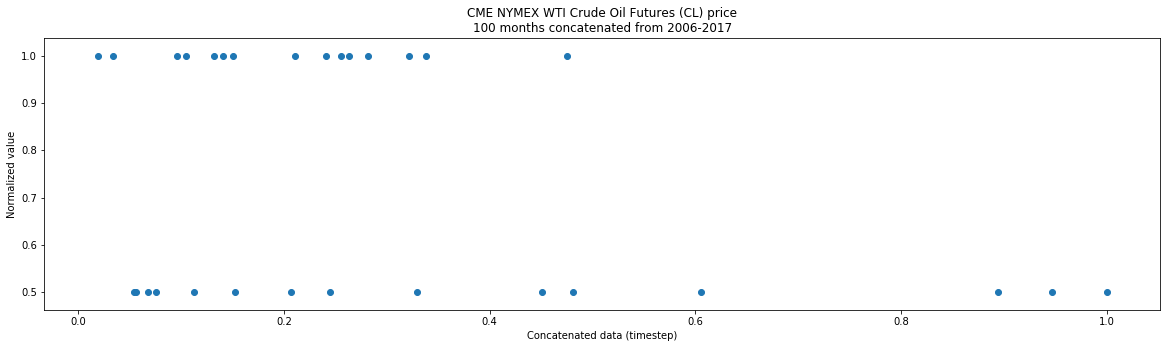

In [10]:
dim=100
bins=30
x_tst = np.array([1.0 ,0.5]*int(bins/2))
wti_all_concat_idx=np.load(d_fold+fn+'_concat_idx.npy')[:bins]
wti_all_concat=np.load(d_fold+fn+'_concat.npy')[:bins]
t_tst = wti_all_concat
plt.scatter(wti_all_concat_idx/np.max(wti_all_concat_idx), x_tst)
plt.xlabel('Concatenated data (timestep)')
plt.ylabel('Normalized value')
plt.title('CME NYMEX WTI Crude Oil Futures (CL) price\n100 months concatenated from 2006-2017')
plt.savefig(plots_fold+'xbound.pdf')


I will next apply derived formulas to compute upper and lower bounds for the volatility, which deep2BDSE will require.


In [4]:
wti_all_concat = np.load(d_fold+'fdata_concat.npy')
wti_all_concat_idx = np.load(d_fold+'fdata_concat_idx.npy')
r_est = np.load(d_fold+'fdata_int.npy')
dim = 100
bins=30
t_dist = np.diff(wti_all_concat_idx/np.max(wti_all_concat_idx))
r_est = np.mean(r_est)
avg_t = np.mean(t_dist) 
t = wti_all_concat_idx/np.max(wti_all_concat_idx)

print('Market interest rate mean=%.4f' % 0.09)  # from other data
# generate true solution to PDE
def test_fxn(t,rpg,c, d=1.0):
    return c*np.exp((rpg**2)*(d-t))  # rpg - sigma(sigma+r/sigma)

sigma = np.zeros(dim)
sigma_max = np.zeros(dim)
sigma_min = np.zeros(dim)

x_tst = np.array([1.0 ,0.5]*int(bins/2))

avg_t_h = np.mean(t_dist[::2])  # high
avg_t_l = np.mean(t_dist[1::2])  # low
std_t = np.std(t_dist, ddof=1)
sigma_popt = np.zeros(len(t)-2)
c_popt = np.zeros(len(t)-2)
u_popt = np.zeros(((len(t)-2),2))
for i in range(0,len(t)-2):
    u_popt_tmp, _ = sp.curve_fit(test_fxn, t[i:i+2], wti_all_concat[i:i+2], p0=(1,5))
    u_popt[i] = u_popt_tmp
u_popt_m = np.mean(u_popt,axis=0)
sigma_popt = u_popt_m[0]
c_popt = u_popt_m[1]
sigma = sigma_popt-0.09  # FOR NOW, ISSUE WITH FINDING r
u_max = 0.25  # from other data
#u_max = c_popt  
sigma_max = np.max(np.abs(sigma-0.09))
sigma_min = np.min(np.abs(sigma+0.09))
t = np.linspace(0,1,30)
# generate u(0,t) for all dimensions
u_theta = test_fxn(1.0, rpg=sigma, c=c_popt, d=1.0) # variable volatility in t
print(u_max)
print('Concat. model has volatility bds %.3f to %.3f' % (0.19,0.41))  # from other data

# 
# plt.figure()
# plt.plot(t, c_popt*np.exp((sigma**2)*(1.0-t)))
# plt.xlabel('Concatenated data (timestep)')
# plt.ylabel('$u(0,[1,0.5,1.0,5,...])$')
# plt.title('Approximate solution to $BSB(t=0,x=[1,0.5,1.0,5,...])$ for training data as derived in Beck et. al.')
# plt.savefig(plots_fold+'u_theta.pdf')
# np.save(data_fold+'u_theta.npy',u_max * 100.0)  # accounting for u on subset (0,1)
# print('$$<U(t=0,x\element [1,0.5,1.0,...]>=%.5f$$' % u_max)

Market interest rate mean=0.0900
0.25
Concat. model has volatility bds 0.190 to 0.410


/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Now we may apply the deep2BSDE algorithm to train the neural network to find optimal parameters for the BSB equation.

In [ ]:
import deep2BSDE_BSB as bsb


bsb.train_nn()


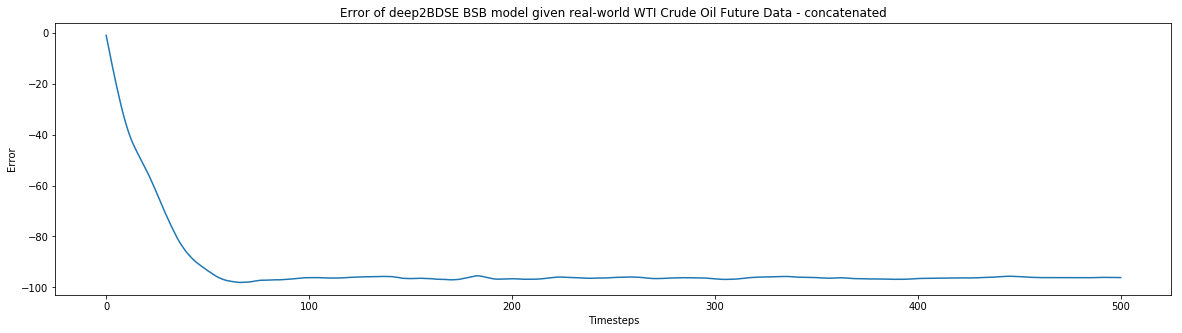

In [5]:
err = pd.read_csv('BSB.csv',delimiter=',')
err_head = list(err)
exp_val = np.asarray((u_max-err[err_head[2]])/u_max)
plt.xlabel('Timesteps')
plt.ylabel('Error')
plt.title('Error of deep2BDSE BSB model given real-world WTI Crude Oil Future Data - concatenated')
plt.plot(exp_val)
plt.savefig('err.pdf')
plt.show()

# Conclusions


### The value $Y_0$ is important in finance as it defines the expected payout of the option. It is between 0,1 due to the normalization criterion. We have learned that the WTI Crude Oil Futures since 2006 have had a volatility that varies between 0.09 and 0.41, with a market interest rate r of 0.09. It is most likely that this future option will continue to have an expected profit of u(t=0,X[0.5,1,...])=~25. 

### We also now have a Black-Scholes-Barenblatt equation with optimal NN parameters for this future which we can use to build a predictive model. From here, we can combine this result with others by applying a similar training algorithm to determine the most profitable (and less volatile) futures in an industry on the market. We might employ a classification algorithm such as a random forest on top of these results.

### The dimensionality of the project was reduced to 30 samples; however data is available since 1984 which means it would be very easy to apply this to larger datasets.

##### References:

[1] Christian Beck, Weinan E: “Machine learning approximation algorithms for high-dimensional fully nonlinear partial differential equations and second-order backward stochastic differential equations”, arxiV, 2017.

[2] M. Avellaneda, A. Levy ∗, and A. ParÁS, “Pricing and hedging derivative securities in markets with uncertain volatilities,” Applied Mathematical Finance, vol. 2, no. 2, pp. 73–88, Jun. 1995.

[3] M. Raissi and G. E. Karniadakis, “Hidden physics models: Machine learning of nonlinear partial differential equations,” Journal of Computational Physics, vol. 357, pp. 125–141, Mar. 2018.
